In [11]:
# Copyright 2020- IBM Inc. All rights reserved
# SPDX-License-Identifier: Apache-2.0

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (22,10)
# import seaborn as sns

In [2]:
plt.rcParams['boxplot.boxprops.linewidth'] = 3
plt.rcParams['boxplot.medianprops.linewidth'] = 3
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = plt.rcParams['xtick.labelsize']

In [3]:
# Load results
results_store_folder = os.path.expanduser('~/tmp/MICCAI2022/')
npz_filename = os.path.join(results_store_folder, "PerfEvalResults_20220228_185805.NPZ.npz")
with np.load(npz_filename) as stored_data:
    T_update = stored_data['T_update']
    JACC_slow= stored_data['JACC_slow']
    JACC= stored_data['JACC']
    cv2trackers_to_use=  list(stored_data['cv2trackers_to_use'])
    slow_trackers_last_n= stored_data['slow_trackers_last_n']
    n_frames= stored_data['n_frames']
    n_frames_slow= stored_data['n_frames_slow']
    max_rots_deg=  stored_data['max_rots_deg']
    fit_flow_funs= list(stored_data['fit_flow_funs'])
    N_reflections= stored_data['N_reflections']
    total_runtime= stored_data['total_runtime']

Indexing: `n_frames, n_frames0, n_rois, N_reflections, max_rot, tracker`  
`T_update[n_frame0, N_refl, rot, tracker]`

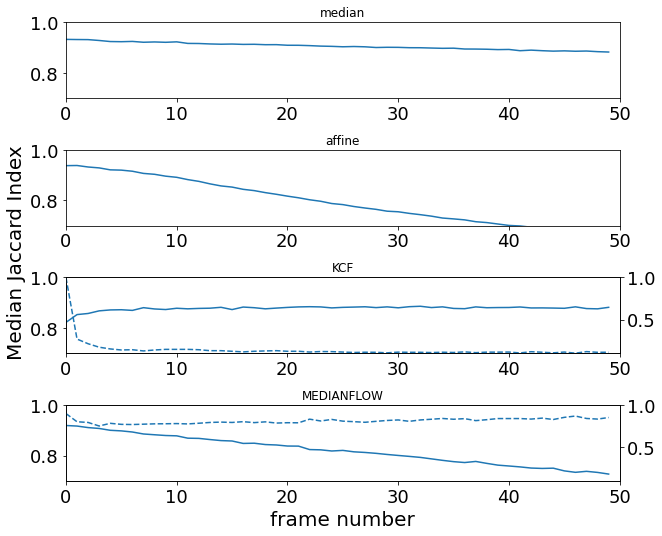

In [4]:
qJ_t = np.nanquantile(JACC, [.25, .5, .75], axis=(1,2,3,4))
fig, ax = plt.subplots(4,1, figsize=(10,8))
ax2 = []
for ii,a in enumerate(ax):
    a.plot(qJ_t[1,:,ii])
    a.set_title((fit_flow_funs+cv2trackers_to_use[:-slow_trackers_last_n])[ii])
#     a.set_ylabel('Median Jaccard Index')
    a.axis(xmin=0, xmax=50, ymin=.7, ymax=1)
    if ii>1:
        a2 = a.twinx()
        ax2.append(a2)
        a2.plot( 1-np.count_nonzero(np.isnan(JACC[...,ii]), axis=(1,2,3,4))/np.prod(JACC.shape[1:-1]), '--' )
    #     a2.set_ylabel('Percentage of ROIs successfully tracked')
        a2.axis(xmin=0, xmax=50, ymin=.1, ymax=1)
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel("frame number")
plt.ylabel('Median Jaccard Index')
# ax3 = fig.add_subplot(111, frameon=False, label='3')
# # hide tick and tick label of the big axis
# plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
# ax3.yaxis.set_label_position('right')
# ax3.set_ylabel('Percentage of ROIs successfully tracked')
plt.tight_layout()

[Text(1, 0, 'median'),
 Text(2, 0, 'affine'),
 Text(3, 0, 'KCF'),
 Text(4, 0, 'MEDIANFLOW'),
 Text(5, 0, 'BOOSTING'),
 Text(6, 0, 'CSRT'),
 Text(7, 0, 'MIL'),
 Text(8, 0, 'TLD')]

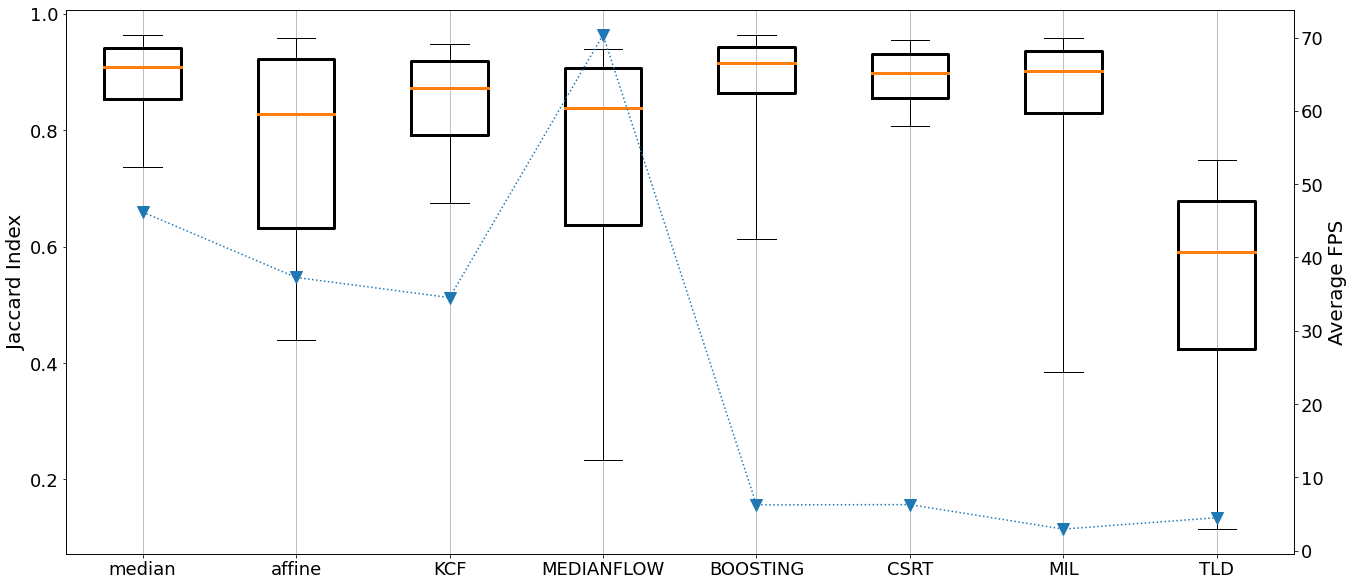

In [5]:
qJ_trkr = np.nanquantile(JACC, [.1, .25, .5, .75, .9], axis=range(5)).T
qJ_trkr_slow = np.nanquantile(JACC_slow, [.1, .25, .5, .75, .9], axis=range(5)).T
fig, ax = plt.subplots()
ax.bxp([
    {'whislo' : J[0], 'q1':J[1], 'med':J[2], 'q3':J[3], 'whishi':J[4]}
    for J in np.vstack((qJ_trkr, qJ_trkr_slow))
], showfliers=False)
ax.grid(True, axis='x')
ax.set_ylabel('Jaccard Index')

n_frames_counted = np.array( [JACC.shape[0]]*JACC.shape[-1] + [JACC_slow.shape[0]]*JACC_slow.shape[-1])
avg_T_update = np.sum(T_update, axis=(0,1,2))/(n_frames_counted*np.prod(T_update.shape[:-1]))
ax2 = ax.twinx()
ax2.plot(1+np.arange(avg_T_update.shape[-1]),1/avg_T_update, 'v:', markersize=12)
ax2.set_ylabel('Average FPS')

ax.set_xticklabels(fit_flow_funs+cv2trackers_to_use)
# plt.savefig('boxplot_all.PDF', pad_inches=0, bbox_inches='tight')

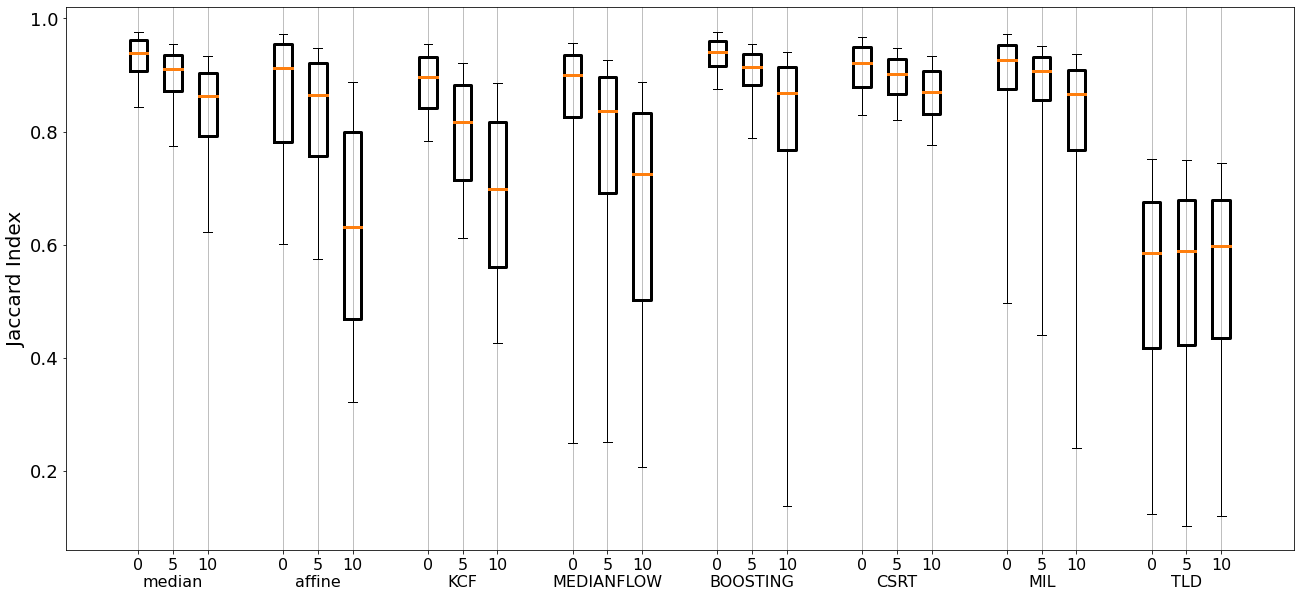

In [7]:
qJ_trkr_rot = np.nanquantile(JACC, [.1, .25, .5, .75, .9], axis=range(4)).T
qJ_trkr_slow_rot = np.nanquantile(JACC_slow, [.1, .25, .5, .75, .9], axis=range(4)).T
fig, ax = plt.subplots()
boxwidth = .12
ax.bxp(sum([[
    {'whislo' : J[0], 'q1':J[1], 'med':J[2], 'q3':J[3], 'whishi':J[4]}
    for J in JJ]
    for JJ in np.vstack((qJ_trkr_rot, qJ_trkr_slow_rot))
], []), showfliers=False,
positions= (np.array([[-2*boxwidth,0,2*boxwidth]]).T+np.arange(8)).flatten(order='F'), widths=boxwidth      
      )
ax.grid(True, axis='x')
ax.set_ylabel('Jaccard Index')

xticklabels = sum([ [f'{max_rots_deg[0]:.0f}', f'{max_rots_deg[1]:.0f}'+'\n'+f, f'{max_rots_deg[2]:.0f}'] for f in fit_flow_funs+cv2trackers_to_use], [])

_ = ax.set_xticklabels(xticklabels, fontsize=16)
# plt.savefig('boxplot_rot.PDF', pad_inches=0, bbox_inches='tight')

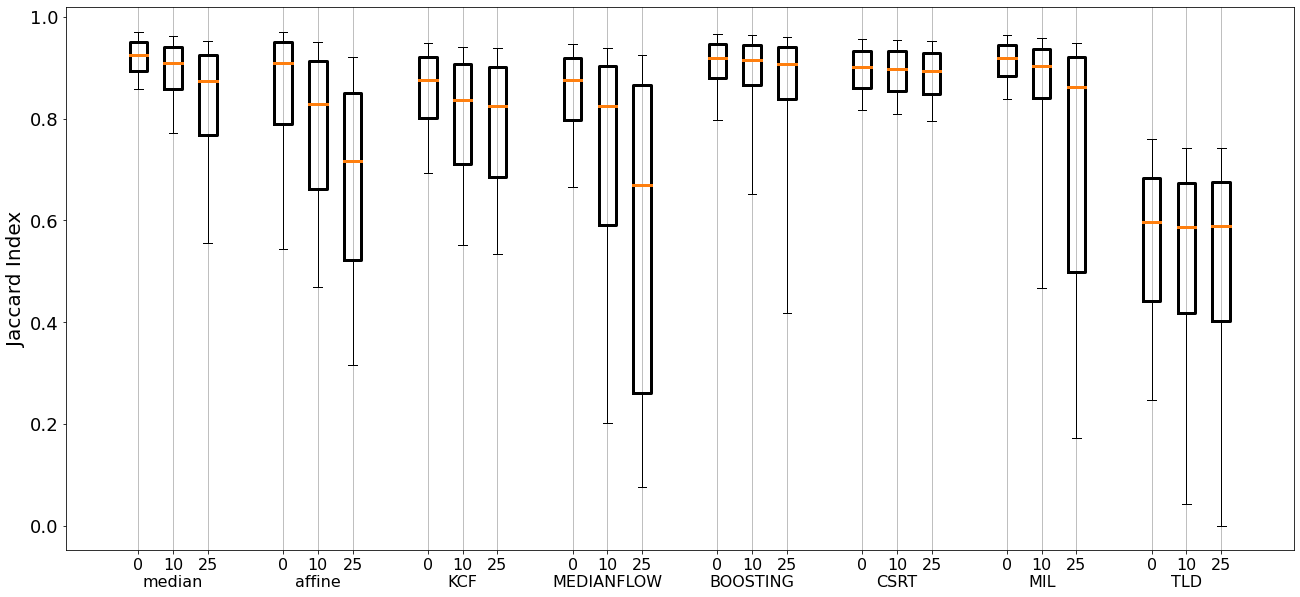

In [8]:
qJ_trkr_ref = np.nanquantile(JACC, [.1, .25, .5, .75, .9], axis=(0,1,2,4)).T
qJ_trkr_slow_ref = np.nanquantile(JACC_slow, [.1, .25, .5, .75, .9], axis=(0,1,2,4)).T
fig, ax = plt.subplots()
boxwidth = .12
ax.bxp(sum([[
    {'whislo' : J[0], 'q1':J[1], 'med':J[2], 'q3':J[3], 'whishi':J[4]}
    for J in JJ]
    for JJ in np.vstack((qJ_trkr_ref, qJ_trkr_slow_ref))
], []), showfliers=False,
positions= (np.array([[-2*boxwidth,0,2*boxwidth]]).T+np.arange(8)).flatten(order='F'), widths=boxwidth      
      )
ax.grid(True, axis='x')
ax.set_ylabel('Jaccard Index')

xticklabels = sum([ [f'{N_reflections[0]:.0f}', f'{N_reflections[1]:.0f}'+'\n'+f, f'{N_reflections[2]:.0f}'] for f in fit_flow_funs+cv2trackers_to_use], [])

_ = ax.set_xticklabels(xticklabels, fontsize=16)
# plt.savefig('boxplot_ref.PDF', pad_inches=0, bbox_inches='tight')